In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 999)
import pickle

In [2]:
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostRegressor, cv
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn.model_selection import TimeSeriesSplit

In [3]:
import feature_engineering_multi

Reading the dataset from csv file to pandas Dataframe object

In [4]:
df = pd.read_csv('/Users/olia/galvanize/ds-final-project/data_all/Fire_Department_Calls_for_Service.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (19,20,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Applying feature engineering script to create/reshape/upddate/drop features. Script is uploaded from outside file.

In [5]:
df_full=feature_engineering_multi.run_features(df)

/Users/olia/galvanize/ds-final-project/scripts/feature_engineering_multi.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  'Location', 'RowID', 'Battalion', 'ALS Unit'], errors='ignore', inplace=True)
/Users/olia/galvanize/ds-final-project/scripts/feature_engineering_multi.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df.dropna(how='any', inplace=True)
/Users/olia/galvanize/ds-final-project/scripts/feature_engineering_multi.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

## MODEL RUN

Splitting dataset into X dataframe and y labels.

In [6]:
y = df_full['Respond to Available']
X = df_full.drop(columns=['Respond to Available'])

Indeces of categorical features.

In [7]:
cat_features=[
    0,
    1,
    3,
    5,
    7,
    9
]

Split X and y into training and testing sets.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

Initiating Pools for CatBoost model

In [9]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, cat_features=cat_features)

In [10]:
model = CatBoostRegressor(iterations=150, depth=16,learning_rate=0.1, one_hot_max_size=3)
model.fit(train_pool)

0:	learn: 40.1500658	total: 19s	remaining: 47m 18s
1:	learn: 36.7288139	total: 37.4s	remaining: 46m 11s
2:	learn: 33.6985427	total: 57.4s	remaining: 46m 51s
3:	learn: 31.0189559	total: 1m 15s	remaining: 45m 43s
4:	learn: 28.6537038	total: 1m 35s	remaining: 45m 57s
5:	learn: 26.5801226	total: 1m 52s	remaining: 45m 2s
6:	learn: 24.7658740	total: 2m 6s	remaining: 43m 13s
7:	learn: 23.1815349	total: 2m 22s	remaining: 42m 9s
8:	learn: 21.8063493	total: 2m 35s	remaining: 40m 41s
9:	learn: 20.6196137	total: 2m 54s	remaining: 40m 36s
10:	learn: 19.6029459	total: 3m 8s	remaining: 39m 43s
11:	learn: 18.7261375	total: 3m 21s	remaining: 38m 38s
12:	learn: 17.9865124	total: 3m 38s	remaining: 38m 18s
13:	learn: 17.3515147	total: 3m 58s	remaining: 38m 35s
14:	learn: 16.8143028	total: 4m 14s	remaining: 38m 9s
15:	learn: 16.3607148	total: 4m 29s	remaining: 37m 36s
16:	learn: 15.9811904	total: 4m 45s	remaining: 37m 13s
17:	learn: 15.6583182	total: 5m 1s	remaining: 36m 47s
18:	learn: 15.3846929	total: 5m

149:	learn: 12.8736055	total: 39m 35s	remaining: 0us


In [11]:
pred = model.predict(test_pool)
pred[pred < 0] = 0

Model parameters

In [12]:
model.get_params()

{'depth': 16,
 'iterations': 150,
 'learning_rate': 0.1,
 'loss_function': 'RMSE',
 'one_hot_max_size': 3}

Feature importance weights and graph

In [13]:
model.get_feature_importance()

[2.9824053467676577,
 6.445509412321168,
 1.4724269858247578,
 0.9929479394959941,
 1.3775110429641366,
 1.6375924067660035,
 1.0906341926309533,
 7.723782794334793,
 2.581476809433641,
 1.9523377165822018,
 1.7578876860301689,
 29.424551763293945,
 1.9861221309388912,
 1.483522303280463,
 1.7102043660752833,
 1.9163580189335176,
 8.513687832797228,
 11.374071726944514,
 13.576969524584687]

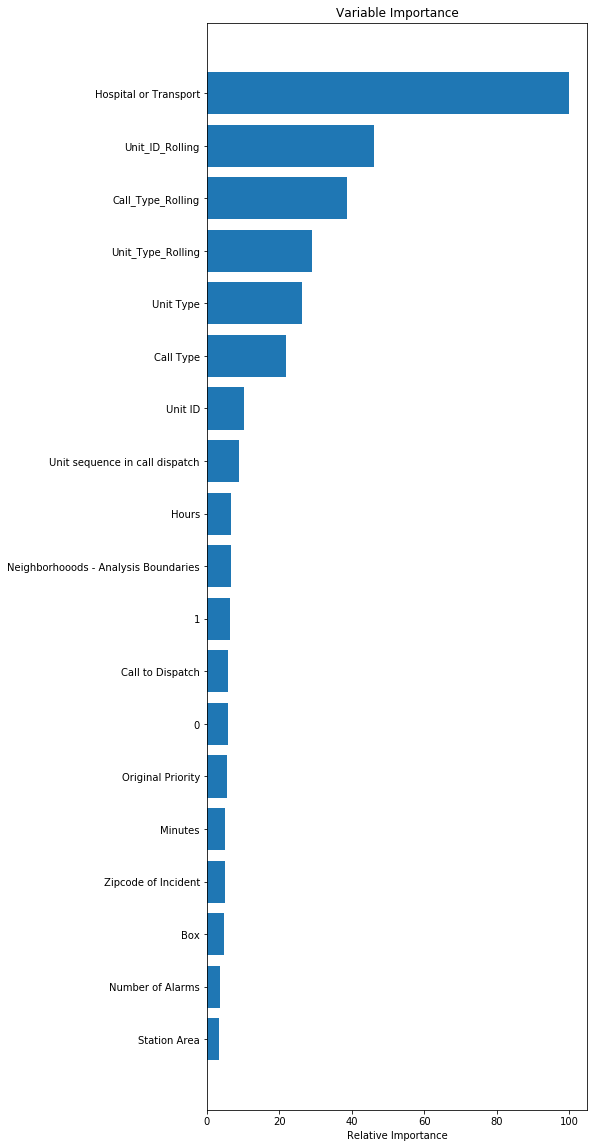

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
feature_importance = model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(15,20))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Evaluation of model scores.

In [15]:
mae = mean_absolute_error(y_test,pred)
mse = mean_squared_error(y_test,pred)
rmse = model.score(test_pool, y_test)
r2_score_value = r2_score(y_test,pred)

In [16]:
print ('Mean absolute error: ', str(mae))
print ('Mean squared error: ', str(mse))
print ('Root squared eroor: ', str(rmse))
print ('Score of determination: ', str(r2_score_value))

Mean absolute error:  10.576248562683313
Mean squared error:  232.46961732049212
Root squared eroor:  15.24704643372059
Score of determination:  0.79349005011962


Storing model via pickle

In [83]:
import pickle
with open('model_catboost.pkl', 'wb') as f:
    # Write the model to a file.
    pickle.dump(model, f)


Reading model via catboost method

In [60]:
model_cbm = model.save_model('catboost_model_cbm.dump')

In [ ]:
Loading models and prediciting values:

In [ ]:
loaded_model = pickle.load(open('model_catboost.pkl', 'rb'))  #from pickle file

In [86]:
loaded_model.predict(test_pool)

array([18.22974696, 69.94062836,  8.03120294, ..., 14.59459362,
        7.90667861, 13.21173939])

In [69]:
loaded_cat = model.load_model('catboost_model_cbm.dump');  #from catboost file

In [87]:
loaded_cat.predict(test_pool)

array([18.22974696, 69.94062836,  8.03120294, ..., 14.59459362,
        7.90667861, 13.21173939])